In [1]:
import numpy as np
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD, Adam

%matplotlib inline
import matplotlib.pyplot as plt


In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [40]:
np.random.seed(9)
X = np.random.randint(-50000, 50000, 10000).reshape(-1,1)
y = X**2

In [41]:
X = np.concatenate([X, [[1]]*X.shape[0]], axis =1)
y = y.reshape(-1,1)

In [42]:
from sklearn.model_selection import train_test_split
train_X = X[X[:,0]%2==1]
train_y = y[X[:,0]%2==1]
test_X = X[X[:,0]%2==0]
test_y = y[X[:,0]%2==0]

In [43]:
X_max = np.max(train_X, axis = 0 )
y_max = np.max(train_y)

train_X = train_X/X_max
test_X = test_X/X_max

train_y = train_y/y_max
test_y = test_y/y_max



train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(train_y).float()

test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).float()

In [44]:
def compute_loss(y_true, y_pred):
    computed_loss = torch.mean((y_pred-y_true).pow(2))/2
    return computed_loss

In [45]:
def initialize_weights(d0, d1):
    return np.random.randn(d0, d1)

In [46]:
def generate_batches(features, target, batch_idx, mini_batch_size):

    batch_X = features[batch_idx*mini_batch_size: (batch_idx+1)*mini_batch_size]
    batch_y = target[batch_idx*mini_batch_size: (batch_idx+1)*mini_batch_size]
    yield batch_X, batch_y

In [47]:
hidden_units = 32

In [48]:
from tqdm import tqdm
#np.random.seed(0)
W1 = initialize_weights(X.shape[1], hidden_units)
#np.random.seed(1)
W2 = initialize_weights(hidden_units, y.shape[1])

W1 = torch.from_numpy(W1).float()
W2 = torch.from_numpy(W2).float()



model = dict()
model["W1"] = W1
model["W2"] = W2

model["W1"].requires_grad = True
model["W2"].requires_grad = True

In [49]:
def forward(X):
    model["H1"] = X.mm(model["W1"])
    model["A1"] = model["H1"].clamp(min=0)
    model["H2"] = model["A1"].mm(model["W2"])
    
    
    return model

In [50]:
def shuffle_dataset(features, target):
    indices = np.arange(0, train_X.shape[0])
    shuffled_indices = np.random.choice(a=indices, size=len(indices))
    return features[shuffled_indices], target[shuffled_indices]

In [51]:
model["W1"].grad

# Using Python Auto Grad for back propogation

100%|██████████| 50/50 [00:02<00:00, 21.25it/s]


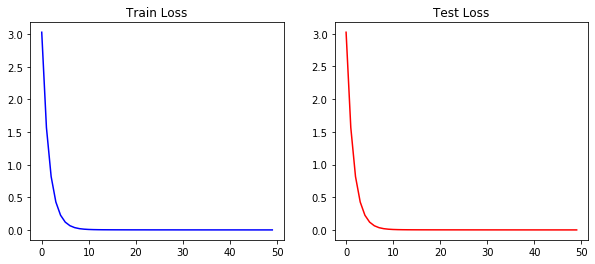

In [52]:
loss_all = []
epochs = 50
mini_batch_size = 32
lr=1e-4

break_flag=0
for epoch in tqdm(range(epochs)): # for each epoch
    observations = train_X.shape[0]
    iterations = (observations//mini_batch_size)-1
    iteration=0

    train_X, train_y = shuffle_dataset(train_X, train_y)

    while iteration<=iterations: 
        # for each mini batch
        for batch_X, batch_y in generate_batches(train_X, train_y, iteration, mini_batch_size):
            model = forward(batch_X)
            loss = compute_loss(batch_y, model["H2"])
            loss.backward()
            
            with torch.no_grad():
                model["W1"]=model["W1"]-lr*model["W1"].grad
                model["W2"]=model["W2"]-lr*model["W2"].grad
                
                
                
            model["W1"].requires_grad = True
            model["W2"].requires_grad = True
            

        iteration+=1
    
    with torch.no_grad():    
        for phase in ["train", "test"]:  
            if phase == "train":
                train_y_pred = forward(train_X)["H2"]
                train_epoch_loss = compute_loss(train_y, train_y_pred).item()
            else:
                test_y_pred = forward(test_X)["H2"]
                test_epoch_loss = compute_loss(test_y, test_y_pred).item()

        # Collecting Loss Values
        loss_all.append((train_epoch_loss, test_epoch_loss))
        all_losses = np.array(loss_all)

fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.title("Train Loss")
plt.plot(np.array(loss_all)[:,0], color="blue")
fig.add_subplot(122)
plt.title("Test Loss")
plt.plot(np.array(loss_all)[:,1], color= "red")




In [53]:
from sklearn.metrics import r2_score
pred = forward(train_X)["H2"].detach().numpy()
r2_score(train_y, pred)

0.9505524503836948

In [54]:
pred = forward(test_X)["H2"].detach().numpy()
r2_score(test_y, pred)

0.9477697063227856

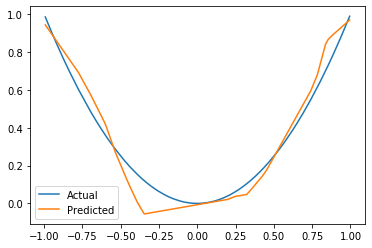

In [55]:
sort_index = np.argsort(train_X[:,0], axis =0)

pred = forward(train_X[sort_index, :])["H2"].detach().numpy()
plt.plot(train_X[sort_index, 0], train_y[sort_index])
plt.plot(train_X[sort_index, 0], pred)
plt.legend(["Actual", "Predicted"])
plt.show()

# Using torch.nn

In [874]:
np.random.seed(9)
X = np.random.randint(-50000, 50000, 10000).reshape(-1,1)
y = X**2

from sklearn.model_selection import train_test_split
train_X = X[X[:,0]%2==1]
train_y = y[X[:,0]%2==1]
test_X = X[X[:,0]%2==0]
test_y = y[X[:,0]%2==0]

X_max = np.max(train_X, axis = 0 )
y_max = np.max(train_y)

train_X = train_X/X_max
test_X = test_X/X_max

train_y = train_y/y_max
test_y = test_y/y_max

In [789]:
train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(train_y).float()

test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).float()

In [790]:
from torch import nn
from torch import functional as F
torch.manual_seed(9)

# Refactor using Sequential API

In [791]:
# 1. Model Architecture - Using Sequential
model = nn.Sequential(nn.Linear(in_features = X.shape[1],out_features = hidden_units, bias=True),
                       nn.ReLU(),
                       nn.Linear(in_features = hidden_units,out_features = 1)
                       )
model = model.to(device)

In [792]:
# 2. Loss
criterion = torch.nn.MSELoss(reduction="mean")

# 3. Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

#4. Training
epochs = 100
for epoch in tqdm(range(epochs)): # for each epoch
    observations = train_X.shape[0]
    iterations = (observations//mini_batch_size)-1
    iteration=0

    train_X, train_y = shuffle_dataset(train_X, train_y)
    model.train()
    while iteration<=iterations: 
        # for each mini batch
        for batch_X, batch_y in generate_batches(train_X, train_y, iteration, mini_batch_size):
            
             # 1. Forward Propogation
            y_pred = model(batch_X.float())
            # 2. Compute Loss
            loss = criterion(y_pred, batch_y.float())

            # 3. Ensure gradients are all zero
            optimizer.zero_grad()
            
            # 4. Back Propogate
            loss.backward()
            
            #5. Update weights
            optimizer.step()
            
            iteration+=1
    
    model.eval()
    with torch.no_grad():    
            for phase in ["train", "test"]:  
                if phase == "train":
                    train_y_pred = model(train_X.float())
                    train_epoch_loss = criterion(train_y_pred, train_y.float()).item()
                else:
                    test_y_pred = model(test_X.float())
                    test_epoch_loss = criterion(test_y_pred, test_y.float()).item()

            # Collecting Loss Values
            loss_all.append((train_epoch_loss, test_epoch_loss))
            all_losses = np.array(loss_all)



100%|██████████| 100/100 [00:05<00:00, 19.59it/s]


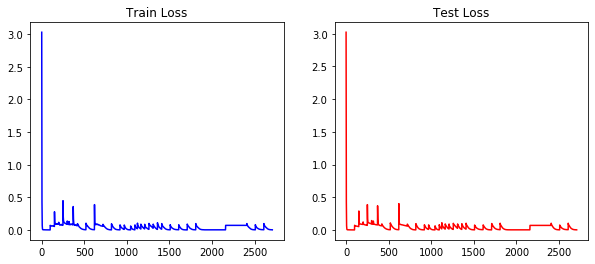

In [793]:
fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.title("Train Loss")
plt.plot(np.array(loss_all)[:,0], color="blue")
fig.add_subplot(122)
plt.title("Test Loss")
plt.plot(np.array(loss_all)[:,1], color= "red")

In [794]:
from sklearn.metrics import r2_score
pred = model(train_X).detach().numpy()
r2_score(train_y, pred)

0.9743824355169226

In [795]:
pred = model(test_X).detach().numpy()
r2_score(test_y, pred)

0.9686837045741387

# Refactor using Module Subclassing
For more complex models

In [796]:
from torch.nn.functional import relu

In [797]:
class MlpRegression(nn.Module):
    def __init__(self, feature_size, hidden_units, num_labels):
        super(MlpRegression, self).__init__()
        self.h1 = nn.Linear(in_features = feature_size, 
                         out_features = hidden_units
                         )
        self.h2 = nn.Linear(in_features = hidden_units,
                         out_features = num_labels)
    def forward(self, x):
        h1 = self.h1(x)
        a1 = relu(h1)
        h2 = self.h2(a1)
        return h2
        

In [798]:
# 1. Model Architecture - Using Sequential
model = MlpRegression(feature_size = X.shape[1],
                      hidden_units = hidden_units,
                      num_labels = y.shape[1])
model = model.to(device)

# 2. Loss
criterion = torch.nn.MSELoss(reduction="mean")

# 3. Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

#4. Training
epochs = 100
for epoch in tqdm(range(epochs)): # for each epoch
    observations = train_X.shape[0]
    iterations = (observations//mini_batch_size)-1
    iteration=0

    train_X, train_y = shuffle_dataset(train_X, train_y)
    model.train()
    while iteration<=iterations: 
        # for each mini batch
        for batch_X, batch_y in generate_batches(train_X, train_y, iteration, mini_batch_size):
            
             # 1. Forward Propogation
            y_pred = model(batch_X.float())
            # 2. Compute Loss
            loss = criterion(y_pred, batch_y.float())

            # 3. Ensure gradients are all zero
            optimizer.zero_grad()
            
            # 4. Back Propogate
            loss.backward()
            
            #5. Update weights
            optimizer.step()
            
            iteration+=1
    
    model.eval()
    with torch.no_grad():    
            for phase in ["train", "test"]:  
                if phase == "train":
                    train_y_pred = model(train_X.float())
                    train_epoch_loss = criterion(train_y_pred, train_y.float()).item()
                else:
                    test_y_pred = model(test_X.float())
                    test_epoch_loss = criterion(test_y_pred, test_y.float()).item()

            # Collecting Loss Values
            loss_all.append((train_epoch_loss, test_epoch_loss))
            all_losses = np.array(loss_all)




100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


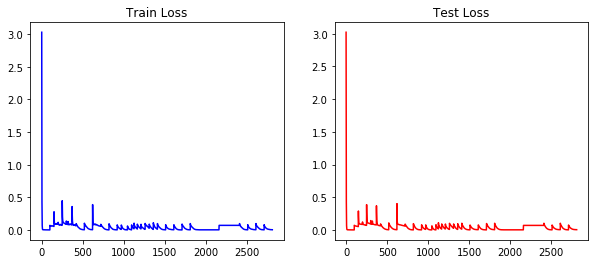

In [799]:
fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.title("Train Loss")
plt.plot(np.array(loss_all)[:,0], color="blue")
fig.add_subplot(122)
plt.title("Test Loss")
plt.plot(np.array(loss_all)[:,1], color= "red")

In [800]:
from sklearn.metrics import r2_score
pred = model(train_X).detach().numpy()
r2_score(train_y, pred)

0.9620549062007734

In [801]:
pred = model(test_X).detach().numpy()
r2_score(test_y, pred)

0.942976225968207

In [1018]:
np.random.seed(9)
X = np.random.randint(-50000, 50000, 10000).reshape(-1,1)
y = X**2

from sklearn.model_selection import train_test_split
train_X = X[X[:,0]%2==1]
train_y = y[X[:,0]%2==1]
test_X = X[X[:,0]%2==0]
test_y = y[X[:,0]%2==0]

X_max = np.max(train_X, axis = 0 )
y_max = np.max(train_y)

train_X = train_X/X_max
test_X = test_X/X_max

train_y = train_y/y_max
test_y = test_y/y_max


# Refactor using Data set Class

In [1019]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [1034]:
# Useful for custom dataset classes and preprocessing

In [1020]:
class RandomDataSet(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Write Complex Logic here
        # Read large datasets here 
       
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [1021]:
train_dataset = RandomDataSet(train_X, train_y)
test_dataset = RandomDataSet(test_X, test_y)

In [1035]:
# for simple dataset creation TensorDataset is the way to go. 

In [ ]:
# TensorDataset(train_X, train_y)

In [1037]:
# Missing requirements in Dataset class
# 1. Batch Generator
# 2. Shuffling


# Refactoring using DataLoader Class

In [1022]:
from torch.utils.data import DataLoader

In [1023]:
train_dl = DataLoader(dataset = train_dataset, 
           batch_size = 32,
           shuffle = True)

test_dl = DataLoader(dataset = test_dataset, 
           batch_size = 32,
           shuffle = True)



In [1024]:
class MlpRegression(nn.Module):
    def __init__(self, feature_size, hidden_units, num_labels):
        super(MlpRegression, self).__init__()
        self.h1 = nn.Linear(in_features = feature_size, 
                         out_features = hidden_units
                         )
        self.h2 = nn.Linear(in_features = hidden_units,
                         out_features = num_labels)
    def forward(self, x):
        h1 = self.h1(x)
        a1 = relu(h1)
        h2 = self.h2(a1)
        return h2
        

In [1025]:
# 1. Model Architecture - Using Module Sub classing
model = MlpRegression(feature_size = X.shape[1],
                      hidden_units = hidden_units,
                      num_labels = y.shape[1])
model = model.to(device)

# 2. Loss
criterion = torch.nn.MSELoss(reduction="mean")

# 3. Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

for epoch in range(epochs):
    model.train()
    all_loss = 0
    for batch_X, batch_y in train_dl:

         # 1. Forward Propogation
        y_pred = model(batch_X.float())
        # 2. Compute Loss
        loss = criterion(y_pred, batch_y.float())

        # 3. Ensure gradients are all zero
        optimizer.zero_grad()

        # 4. Back Propogate
        loss.backward()

        #5. Update weights
        optimizer.step()
        
        all_loss+=loss.item()
    
    epoch_loss = all_loss/(len(train_dl))
    if epoch%10 == 0:
        print("epoch : {}\tloss : {}".format(epoch, epoch_loss))
    
    

epoch : 0	loss : 0.14381300323183024
epoch : 10	loss : 0.06547862725167335
epoch : 20	loss : 0.043780542792210095
epoch : 30	loss : 0.028597007163717776
epoch : 40	loss : 0.018539557410286196
epoch : 50	loss : 0.01221797456139628
epoch : 60	loss : 0.008470006581820264
epoch : 70	loss : 0.006280672877195846
epoch : 80	loss : 0.00502724190024494
epoch : 90	loss : 0.004255320194554574


In [1030]:
def get_predictions(model, dl):
    for idx, (batch_X, batch_y) in enumerate(dl):
        if idx == 0:
            pred = model(batch_X.float())
            true = batch_y
        else:
            pred = torch.cat((pred, model(batch_X.float())), dim=0)
            true = torch.cat((true, batch_y))
    return pred, true

In [1031]:
train_pred, train_y = get_predictions(model, train_dl)
train_pred = train_pred.detach().numpy()
train_y = train_y.detach().numpy()


test_pred, test_y = get_predictions(model, test_dl)
test_pred = test_pred.detach().numpy()
test_y = test_y.detach().numpy()



In [1032]:
r2_score(train_y, train_pred)

0.9559713481186319

In [1033]:
r2_score(test_y, test_pred)

0.9554237741875538